In [9]:
## Import Dependencies
import os, re
from pathlib import Path
import numpy as np
import pandas as pd
from PIL import Image
from tqdm.auto import tqdm

import torch, torchvision
from torchvision import transforms

import torch
import torch.nn as nn
import torchvision.transforms as T
from torchvision.models import resnet50

import matplotlib.pyplot as plt
import torch.nn.functional as F

from torch_geometric.data import Data as PyGData, Batch as PyGBatch
from torch_geometric.nn import GATConv
from torch_geometric.utils import to_dense_batch

from torch.utils.data import Dataset
import math, random, time
import torch.optim as optim
from torch.utils.data import DataLoader, Subset

In [51]:
# -------- CONFIG --------
VIDEO_PATH = Path(r"D:\Datasets\Datasets\EGTEA+\Video\OP01-R05-Cheeseburger.mp4")
GAZE_TXT   = Path(r"D:\Datasets\Datasets\EGTEA+\Gaze\OP01-R05-Cheeseburger.txt")  # adjust path
OUT_CSV    = Path(r"FusedFeatures\OP01-R05-Cheeseburger_fused.csv")
OUT_NPZ_DIR= Path(r"D:\Datasets\Datasets\EGTEA+\FusedFeatures\OP01-R05-Cheeseburger_npz")
OUT_NPZ_DIR.mkdir(parents=True, exist_ok=True)

FRAME_RESIZE = (224, 224)
PATCH_SIZE   = 112
USE_GPU      = True
ALPHA        = 0.7          # fused = ALPHA*visual + (1-ALPHA)*patch
FALLBACK_TO_CENTER_PATCH = True
FRAME_OFFSET = 0            # if needed for absolute vs clip frame indices
SAVE_PER_FRAME_NPZ = True
FPS_FOR_GAZE = 24
GAZE_RESOLUTION = (960, 1280)  # (H, W) used in gaze export
# ------------------------

DEVICE = "cuda" if (torch.cuda.is_available() and USE_GPU) else "cpu"

In [52]:
def parse_gtea_gaze_simple(filename, gaze_resolution=GAZE_RESOLUTION, fps=FPS_FOR_GAZE):
    if not Path(filename).exists():
        print("Gaze file not found:", filename)
        return np.zeros((0,3), dtype=np.float32)
    lines = [ln.rstrip("\n") for ln in open(filename, encoding='utf-8', errors='ignore')]
    start_idx = 0
    for i, ln in enumerate(lines[:80]):
        if "Number of Samples" in ln or ln.strip().startswith("#"):
            start_idx = i + 1
            break
    if start_idx == 0:
        start_idx = 34 if len(lines) > 40 else 0
    body = lines[start_idx:]

    samples = {}
    max_frame = -1

    def _timestr_to_frame(ts):
        try:
            parts = ts.split(":")
            if len(parts) == 4:
                h, m, s, fr = parts
                total_sec = int(h)*3600 + int(m)*60 + int(s)
                return total_sec * fps + int(fr)
        except:
            return None
        return None

    for ln in body:
        if not ln.strip():
            continue
        f_matches = re.findall(r"[Ff]0*(\d+)", ln)
        t_matches = re.findall(r"\d+:\d+:\d+:\d+", ln)
        numeric_token_strs = re.findall(r"[-+]?\d*\.\d+|\d+", ln)
        frame = None
        if f_matches:
            frame = int(f_matches[-1])
        elif t_matches:
            frame = _timestr_to_frame(t_matches[-1])
        else:
            int_candidates = [tok for tok in numeric_token_strs if re.fullmatch(r"\d+", tok)]
            if int_candidates:
                for tok in reversed(int_candidates):
                    if len(tok) <= 7:
                        frame = int(tok); break
                if frame is None:
                    frame = int(int_candidates[-1])
        if frame is None:
            continue

        float_vals = [float(x) for x in numeric_token_strs] if numeric_token_strs else []
        px = py = None
        if len(float_vals) >= 2:
            px, py = float_vals[0], float_vals[1]
        if px is None or py is None:
            continue

        gtype = 3
        if "Fixation" in ln:
            gtype = 1
        elif "Saccade" in ln:
            gtype = 2
        elif "Untracked" in ln or "NoGaze" in ln:
            gtype = 0

        samples.setdefault(frame, []).append((px, py, gtype))
        max_frame = max(max_frame, frame)

    if max_frame < 0:
        return np.zeros((0,3), dtype=np.float32)

    gaze_arr = np.zeros((max_frame+1, 3), dtype=np.float32)
    gaze_arr[:,2] = 0
    H, W = gaze_resolution
    for f, vals in samples.items():
        px_avg = np.mean([v[0] for v in vals])
        py_avg = np.mean([v[1] for v in vals])
        types  = [v[2] for v in vals]
        gtype  = max(set(types), key=types.count)
        nx = np.clip(px_avg, 0, W-1)/float(W)
        ny = np.clip(py_avg, 0, H-1)/float(H)
        gaze_arr[f,0] = nx
        gaze_arr[f,1] = ny
        gaze_arr[f,2] = gtype
    return gaze_arr

# backbone
model = torchvision.models.resnet18(pretrained=True)
model = torch.nn.Sequential(*list(model.children())[:-1])  # (B,512,1,1)
model.eval().to(DEVICE)
preprocess = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(FRAME_RESIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])

def extract_global_feature(frame_bgr):
    img = cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2RGB)
    x = preprocess(img).unsqueeze(0).to(DEVICE)
    with torch.no_grad():
        feat = model(x).squeeze().cpu().numpy()
    return feat.astype(np.float32)

def extract_patch_feature(frame_bgr, cx_norm, cy_norm, patch_px=PATCH_SIZE):
    H, W = frame_bgr.shape[:2]
    cx = int(np.clip(cx_norm, 0.0, 1.0) * (W-1))
    cy = int(np.clip(cy_norm, 0.0, 1.0) * (H-1))
    half = patch_px // 2
    x1, y1 = max(0, cx-half), max(0, cy-half)
    x2, y2 = min(W, cx+half), min(H, cy+half)
    patch = frame_bgr[y1:y2, x1:x2]
    if patch.size == 0:
        if FALLBACK_TO_CENTER_PATCH:
            cx_c, cy_c = W//2, H//2
            x1, y1 = max(0, cx_c-half), max(0, cy_c-half)
            x2, y2 = min(W, cx_c+half), min(H, cy_c+half)
            patch = frame_bgr[y1:y2, x1:x2]
        else:
            return np.zeros((512,), dtype=np.float32)
    patch_rgb = cv2.cvtColor(patch, cv2.COLOR_BGR2RGB)
    x = preprocess(patch_rgb).unsqueeze(0).to(DEVICE)
    with torch.no_grad():
        feat = model(x).squeeze().cpu().numpy()
    return feat.astype(np.float32)

def run_fusion_and_save():
    gaze_arr = parse_gtea_gaze_simple(str(GAZE_TXT))
    cap = cv2.VideoCapture(str(VIDEO_PATH))
    if not cap.isOpened():
        raise RuntimeError(f"Cannot open video: {VIDEO_PATH}")
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT) or 0)
    print(f"Video frames: {total_frames}, gaze frames up to: {gaze_arr.shape[0]-1 if gaze_arr.shape[0]>0 else 'none'}")

    rows = []
    frame_idx = 0
    pbar = tqdm(total=total_frames, desc="Fusing RGB+Gaze")
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        abs_frame_idx = frame_idx + FRAME_OFFSET
        has_gaze = (gaze_arr.shape[0] > 0) and (0 <= abs_frame_idx < gaze_arr.shape[0]) and (gaze_arr[abs_frame_idx,2] != 0)
        if has_gaze:
            cx = float(gaze_arr[abs_frame_idx,0])
            cy = float(gaze_arr[abs_frame_idx,1])
            gtype = int(gaze_arr[abs_frame_idx,2])
            patch_feat = extract_patch_feature(frame, cx, cy, PATCH_SIZE)
        else:
            gtype = 0
            if FALLBACK_TO_CENTER_PATCH:
                cx, cy = 0.5, 0.5
                patch_feat = extract_patch_feature(frame, cx, cy, PATCH_SIZE)
            else:
                cx, cy = (np.nan, np.nan)
                patch_feat = np.zeros((512,), dtype=np.float32)

        visual_feat = extract_global_feature(frame)
        fused = ALPHA * visual_feat + (1.0-ALPHA) * patch_feat

        row = {
            "frame_index": frame_idx,
            "abs_frame_index": abs_frame_idx,
            "gaze_x": float(cx) if not (isinstance(cx,float) and np.isnan(cx)) else "",
            "gaze_y": float(cy) if not (isinstance(cy,float) and np.isnan(cy)) else "",
            "gaze_type": int(gtype)
        }
        fused_dict = {f"fused_{i}": float(v) for i, v in enumerate(fused)}
        row.update(fused_dict)
        rows.append(row)

        if SAVE_PER_FRAME_NPZ:
            np.savez_compressed(OUT_NPZ_DIR / f"frame_{frame_idx:06d}.npz",
                                visual_feat=visual_feat, patch_feat=patch_feat,
                                fused=fused, gaze_type=int(gtype),
                                gaze_x=(cx if not (isinstance(cx,float) and np.isnan(cx)) else None),
                                gaze_y=(cy if not (isinstance(cy,float) and np.isnan(cy)) else None))
        frame_idx += 1
        pbar.update(1)

    pbar.close()
    cap.release()

    df = pd.DataFrame(rows)
    df.to_csv(OUT_CSV, index=False)
    print("Saved fused CSV:", OUT_CSV)
    print("Saved frame NPZ to:", OUT_NPZ_DIR)

run_fusion_and_save()

C:\Users\PAWANESH\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\PAWANESH\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Video frames: 16059, gaze frames up to: 16076


Fusing RGB+Gaze:   0%|          | 0/16059 [00:00<?, ?it/s]

Saved fused CSV: D:\Datasets\Datasets\EGTEA+\FusedFeatures\OP01-R05-Cheeseburger_fused.csv
Saved frame NPZ to: D:\Datasets\Datasets\EGTEA+\FusedFeatures\OP01-R05-Cheeseburger_npz


Visual feat shape: (512,)
Patch feat shape: (512,)
Fused feat shape: (512,)
Gaze: 0.999218761920929 0.0010416667209938169 Type: 1
Frame index: 250


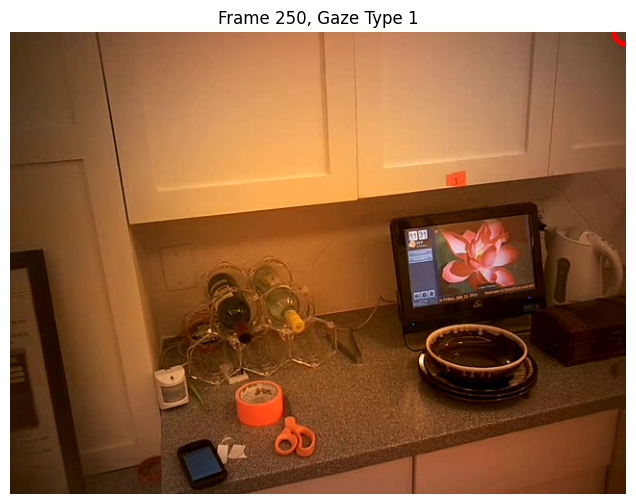

In [18]:
import numpy as np
import cv2
from pathlib import Path
import matplotlib.pyplot as plt

VIDEO_PATH = Path(r"D:\Datasets\Datasets\EGTEA+\Video\OP01-R04-ContinentalBreakfast.mp4")
NPZ_PATH   = Path(r"D:\Datasets\Datasets\EGTEA+\FusedFeatures\OP01-R04-ContinentalBreakfast_npz\frame_000250.npz")

data = np.load(NPZ_PATH)
visual_feat = data["visual_feat"]
patch_feat  = data["patch_feat"]
fused_feat  = data["fused"]
gaze_type   = data["gaze_type"]
gaze_x      = data["gaze_x"]
gaze_y      = data["gaze_y"]

print("Visual feat shape:", visual_feat.shape)
print("Patch feat shape:", patch_feat.shape)
print("Fused feat shape:", fused_feat.shape)
print("Gaze:", gaze_x, gaze_y, "Type:", gaze_type)

frame_idx = int(NPZ_PATH.stem.split("_")[1])
print("Frame index:", frame_idx)

cap = cv2.VideoCapture(str(VIDEO_PATH))
cap.set(cv2.CAP_PROP_POS_FRAMES, frame_idx)
ret, frame = cap.read()
cap.release()
if not ret:
    raise RuntimeError("Could not read frame from video")

frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

if gaze_x is not None and gaze_y is not None and gaze_type != 0:
    H, W = frame_rgb.shape[:2]
    cx = int(float(gaze_x) * W)
    cy = int(float(gaze_y) * H)
    cv2.circle(frame_rgb, (cx, cy), 12, (255, 0, 0), 3)

plt.figure(figsize=(8,6))
plt.imshow(frame_rgb)
plt.axis("off")
plt.title(f"Frame {frame_idx}, Gaze Type {gaze_type}")
plt.show()

## Dataset Loader, Anticipation Model : Encoder, Decoder

In [20]:
from pathlib import Path
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset

IGNORE_INDEX = -1


def _detect_feat_cols_from_fused_df(fused_df: pd.DataFrame, expected_dim: int | None = None):
    """
    Detect feature columns from fused_df.
    Priority:
      1) columns starting with 'fused_'
      2) columns starting with 'feat_'
    Columns are sorted by the integer suffix.
    """
    feat_cols = []
    for prefix in ["fused_", "feat_"]:
        cand = [c for c in fused_df.columns if c.startswith(prefix)]
        if cand:
            # sort by numeric suffix
            def _idx(name):
                try:
                    return int(name.split("_")[1])
                except Exception:
                    return 1e9
            feat_cols = sorted(cand, key=_idx)
            break

    if not feat_cols:
        raise RuntimeError(
            f"Could not detect feature columns in fused_df. "
            f"Expected columns like 'fused_0' or 'feat_0'. "
            f"Got columns: {list(fused_df.columns)[:20]} ..."
        )

    if expected_dim is not None and expected_dim > 0 and len(feat_cols) != expected_dim:
        print(
            f"[WARN] Detected {len(feat_cols)} feature columns, "
            f"but feat_dim={expected_dim}. Using detected columns."
        )

    return feat_cols


class SingleVideoAnticipationDataset(Dataset):
    def __init__(self, fused_df_or_path,
                 labels_df_or_path,
                 t_obs: int,
                 k_fut: int,
                 feat_dim: int,
                 fps: float,
                 horizons_s: list[float]):
        # ----- load fused_df -----
        if isinstance(fused_df_or_path, (str, Path)):
            fused_df = pd.read_csv(fused_df_or_path)
        else:
            fused_df = fused_df_or_path.copy()

        # ----- load labels_df -----
        if isinstance(labels_df_or_path, (str, Path)):
            labels_df = pd.read_csv(labels_df_or_path)
        else:
            labels_df = labels_df_or_path.copy()

        if "frame_index" not in fused_df.columns:
            raise KeyError("fused_df must contain 'frame_index'")

        fused_df["frame_index"] = fused_df["frame_index"].astype(int)
        fused_df = fused_df.set_index("frame_index", drop=False).sort_index()

        self.fused_df = fused_df
        self.labels_df = labels_df.reset_index(drop=True)

        if not all(c in self.labels_df.columns for c in ["StartFrame", "EndFrame"]):
            raise KeyError("labels_df must contain StartFrame and EndFrame")

        self.t_obs = int(t_obs)
        self.k_fut = int(k_fut)

        # ---- detect feature columns automatically (no hardcoded feat_*) ----
        self.feat_cols = _detect_feat_cols_from_fused_df(fused_df, expected_dim=feat_dim)
        self.feat_dim = len(self.feat_cols)

        # ---- time info ----
        self.fps = float(fps)
        assert len(horizons_s) == self.k_fut, "len(horizons_s) must equal k_fut"
        self.horizons_s = list(horizons_s)

        # ---- build samples: one per label row ----
        self.samples = []
        for ridx, row in self.labels_df.iterrows():
            try:
                obs_end = int(row["EndFrame"])
            except Exception:
                continue
            self.samples.append({"label_row_idx": int(ridx), "obs_end": obs_end})

        if len(self.samples) == 0:
            raise RuntimeError("No valid label rows found")

    def __len__(self):
        return len(self.samples)

    # === time-based future labels ===
    def _time_based_future_labels(self, obs_end: int):
        """
        For each horizon t in self.horizons_s (seconds),
        compute future_frame = obs_end + round(t * fps),
        then find which action segment covers that frame.
        """
        labels_df = self.labels_df

        def pick(cols):
            for c in cols:
                if c in labels_df.columns:
                    return c
            return None

        vcol = pick(["Verb_class", "verb", "Verb", "verb_class"])
        ncol = pick(["Noun_class", "noun", "Noun", "noun_class"])
        acol = pick(["Action_class", "action", "Action", "ActionLabel"])

        verb_targets   = []
        noun_targets   = []
        action_targets = []

        for h_sec in self.horizons_s:
            future_frame = obs_end + int(round(h_sec * self.fps))
            seg = labels_df[
                (labels_df["StartFrame"] <= future_frame) &
                (labels_df["EndFrame"]   >= future_frame)
            ]
            if seg.empty:
                verb_targets.append(IGNORE_INDEX)
                noun_targets.append(IGNORE_INDEX)
                action_targets.append(IGNORE_INDEX)
            else:
                row = seg.iloc[0]
                if vcol is not None and not pd.isna(row[vcol]):
                    verb_targets.append(int(row[vcol]))
                else:
                    verb_targets.append(IGNORE_INDEX)

                if ncol is not None and not pd.isna(row[ncol]):
                    noun_targets.append(int(row[ncol]))
                else:
                    noun_targets.append(IGNORE_INDEX)

                if acol is not None and not pd.isna(row[acol]):
                    action_targets.append(int(row[acol]))
                else:
                    action_targets.append(IGNORE_INDEX)

        return {
            "verb":   torch.LongTensor(verb_targets),
            "noun":   torch.LongTensor(noun_targets),
            "action": torch.LongTensor(action_targets),
        }

    def __getitem__(self, idx):
        rec = self.samples[idx]
        obs_end = rec["obs_end"]

        # observation window [obs_start, obs_end]
        obs_start = obs_end - (self.t_obs - 1)
        if obs_start < 0:
            obs_start = 0
            obs_end = obs_start + (self.t_obs - 1)

        fused_idx_min = int(self.fused_df.index.min())
        fused_idx_max = int(self.fused_df.index.max())

        obs_end = min(obs_end, fused_idx_max)
        obs_start = max(obs_end - (self.t_obs - 1), fused_idx_min)

        desired = list(range(obs_start, obs_end + 1))

        # reindex, fill missing frames by ffill/bfill then 0
        sel = self.fused_df.reindex(desired).fillna(method="ffill").fillna(method="bfill").fillna(0.0)

        # ensure we have exactly t_obs frames (pad if needed)
        if sel.shape[0] < self.t_obs:
            if sel.shape[0] == 0:
                # degenerate: no data at all; build all-zero rows
                zero_row = {c: 0.0 for c in self.feat_cols}
                sel = pd.DataFrame([zero_row] * self.t_obs)
            else:
                first = sel.iloc[[0]]
                pads = pd.concat([first] * (self.t_obs - sel.shape[0]), ignore_index=True)
                sel = pd.concat([pads, sel.reset_index(drop=True)], ignore_index=True)

        # no need to add feature columns here; they already exist in fused_df.
        # just take the feature matrix:
        F_window = torch.from_numpy(sel[self.feat_cols].to_numpy(dtype=np.float32))  # (T_obs, feat_dim)

        y_multi = self._time_based_future_labels(obs_end)

        meta = {
            "obs_start": int(obs_start),
            "obs_end":   int(obs_end),
            "label_row_idx": int(rec["label_row_idx"]),
        }
        return F_window, y_multi, meta


class MultiVideoAnticipationDataset(Dataset):
    """
    Accepts explicit lists: fused_csv_paths (list of paths) and label_csv_paths (same-length list).
    Builds samples across videos. Assumes all fused CSVs share the same feature column naming.
    """
    def __init__(self,
                 fused_csv_paths: list[str | Path],
                 label_csv_paths: list[str | Path],
                 t_obs: int,
                 k_fut: int,
                 feat_dim: int):

        assert len(fused_csv_paths) == len(label_csv_paths), "Provide matching lists of fused and label CSVs"

        self.t_obs = int(t_obs)
        self.k_fut = int(k_fut)

        self.samples = []
        self.feat_cols = None
        self.feat_dim = None

        for vid_idx, (fpath, lpath) in enumerate(zip(fused_csv_paths, label_csv_paths)):
            fused_df = pd.read_csv(fpath)
            labels_df = pd.read_csv(lpath)

            if "frame_index" not in fused_df.columns:
                raise KeyError(f"'frame_index' missing in fused CSV: {fpath}")

            fused_df["frame_index"] = fused_df["frame_index"].astype(int)
            fused_df = fused_df.set_index("frame_index", drop=False).sort_index()

            # detect features for the first video, then enforce consistency
            if self.feat_cols is None:
                self.feat_cols = _detect_feat_cols_from_fused_df(fused_df, expected_dim=feat_dim)
                self.feat_dim = len(self.feat_cols)
            else:
                missing = [c for c in self.feat_cols if c not in fused_df.columns]
                if missing:
                    raise RuntimeError(
                        f"Fused CSV {fpath} is missing expected feature columns: {missing[:10]} ..."
                    )

            labels_df = labels_df.reset_index(drop=True)
            for ridx, row in labels_df.iterrows():
                try:
                    obs_end = int(row["EndFrame"])
                except Exception:
                    continue
                self.samples.append({
                    "fused_df": fused_df,
                    "labels_df": labels_df,
                    "vid_idx": vid_idx,
                    "label_row_idx": int(ridx),
                    "obs_end": int(obs_end),
                })

        if len(self.samples) == 0:
            raise RuntimeError("No samples found across the provided fused/label CSVs")

    def __len__(self):
        return len(self.samples)

    def _future_labels(self, labels_df: pd.DataFrame, obs_end: int):
        fut = labels_df[labels_df["StartFrame"] > obs_end].sort_values("StartFrame")

        def pick(cols):
            for c in cols:
                if c in labels_df.columns:
                    return c
            return None

        vcol = pick(["Verb_class", "verb", "Verb", "verb_class"])
        ncol = pick(["Noun_class", "noun", "Noun", "noun_class"])
        acol = pick(["Action_class", "action", "Action", "ActionLabel"])

        def collect(col_name):
            if col_name is None:
                return [IGNORE_INDEX] * self.k_fut
            vals = fut[col_name].tolist()[:self.k_fut]
            while len(vals) < self.k_fut:
                vals.append(IGNORE_INDEX)
            return [int(x) if not pd.isna(x) else IGNORE_INDEX for x in vals]

        return {
            "verb":   torch.LongTensor(collect(vcol)),
            "noun":   torch.LongTensor(collect(ncol)),
            "action": torch.LongTensor(collect(acol)),
        }

    def __getitem__(self, idx):
        rec = self.samples[idx]
        fused_df = rec["fused_df"]
        labels_df = rec["labels_df"]
        obs_end = rec["obs_end"]

        obs_start = obs_end - (self.t_obs - 1)
        if obs_start < 0:
            obs_start = 0
            obs_end = obs_start + (self.t_obs - 1)

        fused_idx_min = int(fused_df.index.min())
        fused_idx_max = int(fused_df.index.max())
        obs_end = min(obs_end, fused_idx_max)
        obs_start = max(obs_end - (self.t_obs - 1), fused_idx_min)

        desired = list(range(obs_start, obs_end + 1))
        sel = fused_df.reindex(desired).fillna(method="ffill").fillna(method="bfill").fillna(0.0)

        if sel.shape[0] < self.t_obs:
            if sel.shape[0] == 0:
                zero_row = {c: 0.0 for c in self.feat_cols}
                sel = pd.DataFrame([zero_row] * self.t_obs)
            else:
                first = sel.iloc[[0]]
                pads = pd.concat([first] * (self.t_obs - sel.shape[0]), ignore_index=True)
                sel = pd.concat([pads, sel.reset_index(drop=True)], ignore_index=True)

        # all feature columns should exist; no per-column assignment
        F_window = torch.from_numpy(sel[self.feat_cols].to_numpy(dtype=np.float32))  # (T_obs, feat_dim)

        y_multi = self._future_labels(labels_df, obs_end)
        meta = {
            "obs_start": int(obs_start),
            "obs_end":   int(obs_end),
            "vid_idx":   int(rec["vid_idx"]),
            "label_row_idx": int(rec["label_row_idx"]),
        }
        return F_window, y_multi, meta


In [21]:
K = 3  # KNN graph
DROP = 0.1

def build_topk_edge_index(features: torch.Tensor, k=K):
    """
    features: (T, D) torch tensor
    returns edge_index: (2, E) long tensor (undirected duplicated edges)
    """
    Tn = int(features.size(0))
    x = F.normalize(features, dim=1)
    sim = torch.matmul(x, x.t())   # (T,T)
    sim.fill_diagonal_(-1.0)
    vals, idxs = torch.topk(sim, k, dim=1)
    src = torch.arange(Tn).unsqueeze(1).expand(-1, k).reshape(-1)
    dst = idxs.reshape(-1)
    edge = torch.stack([src, dst], dim=0)
    edge_rev = torch.stack([dst, src], dim=0)
    return torch.cat([edge, edge_rev], dim=1).long()

class BatchedGAT(nn.Module):
    def __init__(self, in_dim, hid_dim=None, num_layers=3, heads=8, dropout=DROP):
        super().__init__()
        hid = hid_dim or in_dim
        self.convs = nn.ModuleList()
        for i in range(num_layers):
            in_ch = in_dim if i==0 else hid
            self.convs.append(GATConv(in_ch, hid//heads, heads=heads, concat=True, dropout=dropout))
        self.proj = nn.Linear(hid, in_dim)
        self.norm = nn.LayerNorm(in_dim)
        self.act = nn.GELU()
    def forward(self, pyg_batch: PyGBatch, T_per_sample: int):
        x = pyg_batch.x; edge_index = pyg_batch.edge_index
        h = x
        for conv in self.convs:
            h = conv(h, edge_index); h = self.act(h)
        h = self.proj(h)
        node_feats, mask = to_dense_batch(h, batch=pyg_batch.batch)  # (B, max_nodes, D)
        B, max_nodes, D = node_feats.shape
        if max_nodes < T_per_sample:
            pad = torch.zeros(B, T_per_sample - max_nodes, D, device=node_feats.device)
            node_feats = torch.cat([node_feats, pad], dim=1)
        elif max_nodes > T_per_sample:
            node_feats = node_feats[:, :T_per_sample, :]
        return self.norm(node_feats)  # (B, T_per_sample, D)

In [22]:
class SimpleTransformerEncoder(nn.Module):
    def __init__(self, d_model, nhead=8, num_layers=3, dim_feedforward=2048, dropout=DROP, max_len=1000):
        super().__init__()
        enc = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=nhead,
            dim_feedforward=dim_feedforward, dropout=dropout,
            activation='gelu', batch_first=True
        )
        self.encoder = nn.TransformerEncoder(enc, num_layers=num_layers)
        self.pos_emb = nn.Parameter(torch.randn(1, max_len, d_model))
    def forward(self, x):
        B,T,D = x.shape
        pos = self.pos_emb[:, :T, :].to(x.device)
        return self.encoder(x + pos)

class AnticipationModel(nn.Module):
    def __init__(self, feat_dim, num_classes: dict,
                 k_fut=5, gat_layers=3, gat_heads=8,
                 dec_layers=3, dec_heads=8, dropout=DROP):
        super().__init__()
        self.feat_dim = feat_dim; self.k_fut = k_fut
        self.gat = BatchedGAT(in_dim=feat_dim, hid_dim=feat_dim,
                              num_layers=gat_layers, heads=gat_heads,
                              dropout=dropout)
        self.encoder = SimpleTransformerEncoder(d_model=feat_dim, nhead=dec_heads, num_layers=3)
        dec_layer = nn.TransformerDecoderLayer(
            d_model=feat_dim, nhead=dec_heads,
            dim_feedforward=feat_dim*4, dropout=dropout,
            activation='gelu', batch_first=True
        )
        self.decoder = nn.TransformerDecoder(dec_layer, num_layers=dec_layers)
        self.queries = nn.Parameter(torch.randn(1, k_fut, feat_dim))
        assert isinstance(num_classes, dict)
        self.verb_head   = nn.Linear(feat_dim, num_classes["verb"])
        self.noun_head   = nn.Linear(feat_dim, num_classes["noun"])
        self.action_head = nn.Linear(feat_dim, num_classes["action"])

    def forward(self, F_batch):
        # F_batch: (B, T, D)
        B,T,D = F_batch.shape
        device = F_batch.device
        data_list=[]
        for b in range(B):
            x = F_batch[b]
            edge_index = build_topk_edge_index(x.detach().cpu(), k=K).to(device)
            data_list.append(PyGData(x=x, edge_index=edge_index))
        pyg_batch = PyGBatch.from_data_list(data_list).to(device)
        G = self.gat(pyg_batch, T_per_sample=T)   # (B,T,D)
        H = self.encoder(F_batch)                 # (B,T,D)
        U = H + G
        q = self.queries.expand(B, -1, -1).to(device)
        dec_out = self.decoder(tgt=q, memory=U)   # (B, K_fut, D)
        return {
            "verb":   self.verb_head(dec_out),
            "noun":   self.noun_head(dec_out),
            "action": self.action_head(dec_out)
        }

In [23]:
import torch.nn.functional as F

def masked_cross_entropy(logits, labels, ignore_index=IGNORE_INDEX):
    B,K,C = logits.shape
    logits_flat = logits.view(B*K, C)
    labels_flat = labels.view(B*K)
    loss_flat = F.cross_entropy(logits_flat, labels_flat, reduction='none', ignore_index=ignore_index)
    mask = (labels_flat != ignore_index).float()
    valid = mask.sum()

    if valid == 0:
        # zero scalar connected to logits, gradient = 0, but backward() is valid
        return (logits_flat * 0.0).sum()

    return (loss_flat * mask).sum() / valid


def topk_accuracy_per_task(logits, labels, topk=(1,5), ignore_index=IGNORE_INDEX):
    """
    logits: (B,K,C), labels: (B,K)
    returns dict with 'per_h{h}_top{k}' and 'overall_top{k}'
    """
    B,K,C = logits.shape
    res = {}
    overall = {k:0 for k in topk}
    total_cnt = 0
    preds_topk = logits.topk(max(topk), dim=-1)[1]  # (B,K,maxk)
    for h in range(K):
        lab = labels[:,h]; mask = (lab != ignore_index); cnt = int(mask.sum().item())
        for k in topk:
            if cnt == 0:
                res.setdefault(f"per_h{h+1}_top{k}", None)
                continue
            predk = preds_topk[:,h,:k]  # (B,k)
            lab_exp = lab.unsqueeze(1).expand(-1, k)
            hits = (predk == lab_exp)
            hit = int(hits[mask].any(dim=1).float().sum().item())
            res[f"per_h{h+1}_top{k}"] = hit / cnt
            overall[k] += hit
        total_cnt += cnt
    for k in topk:
        res[f"overall_top{k}"] = overall[k] / total_cnt if total_cnt>0 else None
    return res

## Training Testing

In [25]:
from sklearn.metrics import precision_recall_fscore_support
# ------------- CONFIG -------------
FUSED_CSV_PATH = r"D:\Datasets\Datasets\EGTEA+\FusedFeatures\OP01-R01-PastaSalad_fused.csv"
LABEL_CSV_PATH = r"D:\Datasets\Datasets\EGTEA+\Labels\OP01-R01-PastaSalad_Label.csv"
BEST_MODEL_PATH = Path(r"D:\Datasets\Datasets\EGTEA+\Model\OP01-R01-PastaSalad_Fused_model.pth")

# Hyperparams
T_OBS = 90
FEAT_DIM = 512
BATCH_SIZE = 8
NUM_EPOCHS = 30
LR = 1e-4
WD = 1e-4
NUM_WORKERS = 0

# === Time-based anticipation config ===
FPS = 30.0  # <-- set this correctly for your EPIC videos
HORIZONS_S = [0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2]   # seconds into the future
K_FUT = len(HORIZONS_S)               # model will output one label per horizon
# =====================================


DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

def detect_num_classes_from_labels_df(labels_df):
    verbs = set()
    nouns = set()
    actions = set()
    for cand in ["Verb_class", "verb", "Verb", "verb_class"]:
        if cand in labels_df.columns:
            verbs.update(labels_df[cand].dropna().astype(int).tolist())
            break
    for cand in ["Noun_class", "noun", "Noun", "noun_class"]:
        if cand in labels_df.columns:
            nouns.update(labels_df[cand].dropna().astype(int).tolist())
            break
    for cand in ["Action_class", "action", "Action", "ActionLabel"]:
        if cand in labels_df.columns:
            actions.update(labels_df[cand].dropna().astype(int).tolist())
            break
    nv = (max(verbs) + 1) if len(verbs) > 0 else 1
    nn_ = (max(nouns) + 1) if len(nouns) > 0 else 1
    na = (max(actions) + 1) if len(actions) > 0 else 1
    return {"verb": int(nv), "noun": int(nn_), "action": int(na)}


def topk_counts(logits, labels, k):
    # logits: (B, K_fut, C); labels: (B, K_fut)
    with torch.no_grad():
        B, K, C = logits.shape
        topk_preds = logits.topk(k, dim=-1)[1]  # (B, K, k)
        hits = 0
        total = 0
        for h in range(K):
            lab = labels[:, h]  # (B,)
            mask = (lab != IGNORE_INDEX)
            if int(mask.sum().item()) == 0:
                continue
            predk = topk_preds[:, h, :]  # (B, k)
            lab_exp = lab.unsqueeze(1).expand(-1, k)
            masked_pred = predk[mask]   # (M, k)
            masked_lab = lab_exp[mask]  # (M, k)
            hit_vec = (masked_pred == masked_lab).any(dim=1).float()
            hits += int(hit_vec.sum().item())
            total += int(mask.sum().item())
        return hits, total


# Load fused and labels
fused_df = pd.read_csv(FUSED_CSV_PATH)
labels_df = pd.read_csv(LABEL_CSV_PATH)

# Dataset
dataset = SingleVideoAnticipationDataset(
    fused_df,
    labels_df,
    t_obs=T_OBS,
    k_fut=K_FUT,        # must equal len(HORIZONS_S)
    feat_dim=FEAT_DIM,
    fps=FPS,
    horizons_s=HORIZONS_S
)

# split indices for train/val (60/40)
indices = list(range(len(dataset)))
random.seed(42)
random.shuffle(indices)
split_at = int(0.6 * len(indices))
train_idx = indices[:split_at]
val_idx = indices[split_at:]

train_ds = Subset(dataset, train_idx)
val_ds = Subset(dataset, val_idx)

train_loader = DataLoader(
    train_ds,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=(DEVICE == "cuda")
)
val_loader = DataLoader(
    val_ds,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=(DEVICE == "cuda")
)

# detect number of classes and instantiate model
num_classes = detect_num_classes_from_labels_df(labels_df)
print("Detected num_classes:", num_classes)
model = AnticipationModel(
    feat_dim=FEAT_DIM,
    num_classes=num_classes,
    k_fut=K_FUT
).to(DEVICE)


# ================= MODEL PARAMETER COUNT =================
def count_parameters(model):
    total = sum(p.numel() for p in model.parameters())
    trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return total, trainable

total_params, trainable_params = count_parameters(model)

print("\n========== MODEL PARAMETERS ==========")
print(f"Total parameters     : {total_params/1e6:.2f} M")
print(f"Trainable parameters : {trainable_params/1e6:.2f} M")
print("=====================================\n")


# ================= MODEL FLOPs =================
from thop import profile

model.eval()

dummy_input = torch.randn(
    1, T_OBS, FEAT_DIM
).to(DEVICE)

macs, params = profile(
    model,
    inputs=(dummy_input,),
    verbose=False
)

print("========== MODEL FLOPs ==========")
print(f"MACs  : {macs/1e9:.2f} G")
print(f"FLOPs : {(2*macs)/1e9:.2f} G")
print("================================\n")



# ================= INFERENCE LATENCY =================
def measure_latency(model, device, runs=100):
    model.eval()
    dummy = torch.randn(1, T_OBS, FEAT_DIM).to(device)

    # warm-up
    for _ in range(10):
        _ = model(dummy)

    if device == "cuda":
        torch.cuda.synchronize()

    start = time.time()
    for _ in range(runs):
        _ = model(dummy)

    if device == "cuda":
        torch.cuda.synchronize()

    avg_latency = (time.time() - start) / runs
    return avg_latency * 1000  # ms


latency_ms = measure_latency(model, DEVICE)

print("========== INFERENCE LATENCY ==========")
print(f"Average latency per sample: {latency_ms:.2f} ms")
print("======================================\n")



opt = optim.Adam(model.parameters(), lr=LR, weight_decay=WD)
sched = optim.lr_scheduler.ReduceLROnPlateau(opt, mode='min', factor=0.5, patience=3)

best_val_loss = float("inf")


Detected num_classes: {'verb': 102, 'noun': 39, 'action': 46}

========== MODEL PARAMETERS ==========
Total parameters     : 23.74 M
Trainable parameters : 23.74 M

========== MODEL FLOPs ==========
MACs  : 0.08 G
FLOPs : 0.15 G

========== INFERENCE LATENCY ==========
Average latency per sample: 19.34 ms



In [ ]:
for epoch in range(1, NUM_EPOCHS + 1):
    t0 = time.time()

    # ------------- TRAIN -------------
    model.train()
    train_loss_sum = 0.0
    train_samples = 0
    train_counts = {
        "verb_top1": [0, 0], "verb_top5": [0, 0],
        "noun_top1": [0, 0], "noun_top5": [0, 0],
        "action_top1": [0, 0], "action_top5": [0, 0]
    }

    pbar = tqdm(train_loader, desc=f"Epoch {epoch} Train", leave=False)
    for F_batch, y_multi, meta in pbar:
        F_batch = F_batch.to(DEVICE)               # (B, T, D)
        y_v = y_multi["verb"].to(DEVICE)           # (B, K_fut)
        y_n = y_multi["noun"].to(DEVICE)
        y_a = y_multi["action"].to(DEVICE)

        opt.zero_grad()
        logits = model(F_batch)   # dict: "verb"/"noun"/"action" -> (B, K_fut, C)

        loss_v = masked_cross_entropy(logits["verb"], y_v)
        loss_n = masked_cross_entropy(logits["noun"], y_n)
        loss_a = masked_cross_entropy(logits["action"], y_a)
        loss = loss_a + 0.5 * loss_v + 0.5 * loss_n

        loss.backward()
        opt.step()

        b = F_batch.size(0)
        train_loss_sum += float(loss.item()) * b
        train_samples += b

        for (task, lab, lg) in [
            ("verb", y_v, logits["verb"]),
            ("noun", y_n, logits["noun"]),
            ("action", y_a, logits["action"])
        ]:
            h1, t1 = topk_counts(lg.detach().cpu(), lab.detach().cpu(), k=1)
            h5, t5 = topk_counts(lg.detach().cpu(), lab.detach().cpu(), k=5)
            train_counts[f"{task}_top1"][0] += h1
            train_counts[f"{task}_top1"][1] += t1
            train_counts[f"{task}_top5"][0] += h5
            train_counts[f"{task}_top5"][1] += t5

    train_loss = train_loss_sum / max(1, train_samples)
    train_metrics = {}
    for task in ["verb", "noun", "action"]:
        h1, t1 = train_counts[f"{task}_top1"]
        h5, t5 = train_counts[f"{task}_top5"]
        train_metrics[f"{task}_top1"] = (h1 / t1) if t1 > 0 else None
        train_metrics[f"{task}_top5"] = (h5 / t5) if t5 > 0 else None

    # ------------- VALIDATION -------------
    model.eval()
    val_loss_sum = 0.0
    val_samples = 0
    val_counts = {
        "verb_top1": [0, 0], "verb_top5": [0, 0],
        "noun_top1": [0, 0], "noun_top5": [0, 0],
        "action_top1": [0, 0], "action_top5": [0, 0]
    }

    # store logits/labels for per-horizon + P/R/F1 metrics
    val_logits_store = {"verb": [], "noun": [], "action": []}
    val_labels_store = {"verb": [], "noun": [], "action": []}

    with torch.no_grad():
        pbar = tqdm(val_loader, desc=f"Epoch {epoch} Val", leave=False)
        for F_batch, y_multi, meta in pbar:
            F_batch = F_batch.to(DEVICE)
            y_v = y_multi["verb"].to(DEVICE)
            y_n = y_multi["noun"].to(DEVICE)
            y_a = y_multi["action"].to(DEVICE)

            logits = model(F_batch)
            loss_v = masked_cross_entropy(logits["verb"], y_v)
            loss_n = masked_cross_entropy(logits["noun"], y_n)
            loss_a = masked_cross_entropy(logits["action"], y_a)
            loss = loss_a + 0.5 * loss_v + 0.5 * loss_n

            b = F_batch.size(0)
            val_loss_sum += float(loss.item()) * b
            val_samples += b

            for (task, lab, lg) in [
                ("verb", y_v, logits["verb"]),
                ("noun", y_n, logits["noun"]),
                ("action", y_a, logits["action"])
            ]:
                h1, t1 = topk_counts(lg.detach().cpu(), lab.detach().cpu(), k=1)
                h5, t5 = topk_counts(lg.detach().cpu(), lab.detach().cpu(), k=5)
                val_counts[f"{task}_top1"][0] += h1
                val_counts[f"{task}_top1"][1] += t1
                val_counts[f"{task}_top5"][0] += h5
                val_counts[f"{task}_top5"][1] += t5

            # store for per-horizon + P/R/F1 metrics
            val_logits_store["verb"].append(logits["verb"].detach().cpu())
            val_logits_store["noun"].append(logits["noun"].detach().cpu())
            val_logits_store["action"].append(logits["action"].detach().cpu())
            val_labels_store["verb"].append(y_v.detach().cpu())
            val_labels_store["noun"].append(y_n.detach().cpu())
            val_labels_store["action"].append(y_a.detach().cpu())

    val_loss = val_loss_sum / max(1, val_samples)

    # overall val metrics (top-1/top-5 over all horizons)
    val_metrics = {}
    for task in ["verb", "noun", "action"]:
        h1, t1 = val_counts[f"{task}_top1"]
        h5, t5 = val_counts[f"{task}_top5"]
        val_metrics[f"{task}_top1"] = (h1 / t1) if t1 > 0 else None
        val_metrics[f"{task}_top5"] = (h5 / t5) if t5 > 0 else None

    # per-horizon metrics (time-based)
    per_horizon_metrics = {"verb": {}, "noun": {}, "action": {}}
    for task in ["verb", "noun", "action"]:
        if len(val_logits_store[task]) == 0:
            continue
        logits_all = torch.cat(val_logits_store[task], dim=0)  # (N, K_fut, C)
        labels_all = torch.cat(val_labels_store[task], dim=0)  # (N, K_fut)
        m = topk_accuracy_per_task(
            logits_all,
            labels_all,
            topk=(1, 5),
            ignore_index=IGNORE_INDEX
        )
        per_horizon_metrics[task] = m

    # macro precision / recall / F1 over all horizons (validation)
    prf_metrics = {"verb": {}, "noun": {}, "action": {}}
    for task in ["verb", "noun", "action"]:
        if len(val_logits_store[task]) == 0:
            continue

        logits_all = torch.cat(val_logits_store[task], dim=0)
        labels_all = torch.cat(val_labels_store[task], dim=0)

        preds_all = logits_all.argmax(dim=-1)  # (N, K_fut)
        mask = (labels_all != IGNORE_INDEX)
        if mask.sum().item() == 0:
            continue

        y_true = labels_all[mask].numpy()
        y_pred = preds_all[mask].numpy()

        p, r, f1, _ = precision_recall_fscore_support(
            y_true,
            y_pred,
            average="macro",
            zero_division=0
        )
        prf_metrics[task]["precision"] = p
        prf_metrics[task]["recall"] = r
        prf_metrics[task]["f1"] = f1

    # mean Top-5 recall across horizons for each task
    mean_top5_recall = {}
    for task in ["verb", "noun", "action"]:
        mh = per_horizon_metrics[task]
        if not mh:
            mean_top5_recall[task] = None
            continue

        vals = []
        for h_idx in range(K_FUT):
            key = f"per_h{h_idx+1}_top5"
            if key in mh and mh[key] is not None:
                vals.append(mh[key])
        mean_top5_recall[task] = float(np.mean(vals)) if len(vals) > 0 else None

    # scheduler + logging
    sched.step(val_loss)
    elapsed = time.time() - t0

    print(f"Epoch {epoch}/{NUM_EPOCHS} | Time {elapsed:.1f}s")
    print(f"  Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")
    for task in ["verb", "noun", "action"]:
        print(
            f"  {task.upper():6s} Train Top1: {train_metrics[f'{task}_top1']}, "
            f"Top5: {train_metrics[f'{task}_top5']}; "
            f"Val Top1: {val_metrics[f'{task}_top1']}, "
            f"Top5: {val_metrics[f'{task}_top5']}"
        )

    # print macro precision / recall / F1 (validation)
    for task in ["verb", "noun", "action"]:
        if prf_metrics[task]:
            p = prf_metrics[task]["precision"]
            r = prf_metrics[task]["recall"]
            f1 = prf_metrics[task]["f1"]
            print(
                f"  {task.upper():6s} Val Precision: {p:.4f}, "
                f"Recall: {r:.4f}, F1: {f1:.4f}"
            )

    # print mean Top-5 recall
    print("  ---- Mean Top-5 Recall (validation) ----")
    for task in ["verb", "noun", "action"]:
        print(
            f"     {task.upper():6s}  Mean Top-5 Recall: {mean_top5_recall[task]}"
        )

    # print per-horizon by seconds
    for task in ["verb", "noun", "action"]:
        mh = per_horizon_metrics[task]
        if not mh:
            continue
        print(f"  {task.upper():6s} per-horizon (time-based):")
        for h_idx, t_sec in enumerate(HORIZONS_S):
            key1 = f"per_h{h_idx+1}_top1"
            key5 = f"per_h{h_idx+1}_top5"
            v1 = mh.get(key1, None)
            v5 = mh.get(key5, None)
            print(f"    @ {t_sec:4.2f}s  Top1: {v1}  Top5: {v5}")
        print(
            f"    overall_top1: {mh.get('overall_top1', None)}, "
            f"overall_top5: {mh.get('overall_top5', None)}"
        )

    # optional: save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(
            {
                'epoch': epoch,
                'model_state': model.state_dict(),
                'opt_state': opt.state_dict(),
                'val_loss': val_loss
            },
            BEST_MODEL_PATH
        )
        print(f"[SAVED BEST] -> {BEST_MODEL_PATH}")

print("Training finished.")

Epoch 1 Train:   0%|          | 0/37 [00:00<?, ?it/s]

Epoch 1 Val:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 1/30 | Time 9.0s
  Train Loss: 5.3822 | Val Loss: 4.0991
  VERB   Train Top1: 0.16873065015479877, Top5: 0.4179566563467492; Val Top1: 0.32950631458094143, Top5: 0.6130884041331802
  NOUN   Train Top1: 0.4218266253869969, Top5: 0.8939628482972136; Val Top1: 0.5120551090700345, Top5: 0.9150401836969001
  ACTION Train Top1: 0.24148606811145512, Top5: 0.628482972136223; Val Top1: 0.5384615384615384, Top5: 0.8117106773823192
  VERB   Val Precision: 0.1021, Recall: 0.1524, F1: 0.0889
  NOUN   Val Precision: 0.2109, Recall: 0.2307, F1: 0.2066
  ACTION Val Precision: 0.2624, Recall: 0.3326, F1: 0.2842
  ---- Mean Top-5 Recall (validation) ----
     VERB    Mean Top-5 Recall: 0.6119254017573454
     NOUN    Mean Top-5 Recall: 0.9152998604145035
     ACTION  Mean Top-5 Recall: 0.8116962116701565
  VERB   per-horizon (time-based):
    @ 0.25s  Top1: 0.2631578947368421  Top5: 0.5578947368421052
    @ 0.50s  Top1: 0.31683168316831684  Top5: 0.5643564356435643
    @ 0.75s  Top1: 0.27927927927

Epoch 2 Train:   0%|          | 0/37 [00:00<?, ?it/s]

Epoch 2 Val:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 2/30 | Time 7.0s
  Train Loss: 3.4564 | Val Loss: 3.1067
  VERB   Train Top1: 0.39164086687306504, Top5: 0.75; Val Top1: 0.49483352468427094, Top5: 0.7393800229621125
  NOUN   Train Top1: 0.5944272445820433, Top5: 0.9628482972136223; Val Top1: 0.5924225028702641, Top5: 0.9437428243398392
  ACTION Train Top1: 0.5495356037151703, Top5: 0.9171826625386997; Val Top1: 0.6326061997703789, Top5: 0.8851894374282434
  VERB   Val Precision: 0.1888, Recall: 0.2522, F1: 0.1800
  NOUN   Val Precision: 0.2918, Recall: 0.2543, F1: 0.2442
  ACTION Val Precision: 0.3294, Recall: 0.4108, F1: 0.3571
  ---- Mean Top-5 Recall (validation) ----
     VERB    Mean Top-5 Recall: 0.7374436125478334
     NOUN    Mean Top-5 Recall: 0.9440344934091678
     ACTION  Mean Top-5 Recall: 0.8868132983753099
  VERB   per-horizon (time-based):
    @ 0.25s  Top1: 0.4105263157894737  Top5: 0.6631578947368421
    @ 0.50s  Top1: 0.44554455445544555  Top5: 0.6732673267326733
    @ 0.75s  Top1: 0.45045045045045046  Top5: 

Epoch 3 Train:   0%|          | 0/37 [00:00<?, ?it/s]

Epoch 3 Val:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 3/30 | Time 7.5s
  Train Loss: 2.3691 | Val Loss: 2.3992
  VERB   Train Top1: 0.586687306501548, Top5: 0.8668730650154799; Val Top1: 0.5855338691159586, Top5: 0.870264064293915
  NOUN   Train Top1: 0.6710526315789473, Top5: 0.989938080495356; Val Top1: 0.6601607347876005, Top5: 0.9598163030998852
  ACTION Train Top1: 0.7476780185758514, Top5: 0.968266253869969; Val Top1: 0.7049368541905855, Top5: 0.9667049368541906
  VERB   Val Precision: 0.3139, Recall: 0.3572, F1: 0.2903
  NOUN   Val Precision: 0.3546, Recall: 0.3270, F1: 0.3175
  ACTION Val Precision: 0.5287, Recall: 0.4698, F1: 0.4626
  ---- Mean Top-5 Recall (validation) ----
     VERB    Mean Top-5 Recall: 0.8712517590057975
     NOUN    Mean Top-5 Recall: 0.9600874463042259
     ACTION  Mean Top-5 Recall: 0.9667886302917569
  VERB   per-horizon (time-based):
    @ 0.25s  Top1: 0.6  Top5: 0.8736842105263158
    @ 0.50s  Top1: 0.5247524752475248  Top5: 0.8910891089108911
    @ 0.75s  Top1: 0.5225225225225225  Top5: 0.8738738

Epoch 4 Train:   0%|          | 0/37 [00:00<?, ?it/s]

Epoch 4 Val:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 4/30 | Time 7.6s
  Train Loss: 1.8252 | Val Loss: 1.7196
  VERB   Train Top1: 0.653250773993808, Top5: 0.9380804953560371; Val Top1: 0.730195177956372, Top5: 0.9138920780711826
  NOUN   Train Top1: 0.7120743034055728, Top5: 0.989938080495356; Val Top1: 0.6865671641791045, Top5: 0.9862227324913893
  ACTION Train Top1: 0.7886996904024768, Top5: 0.9876160990712074; Val Top1: 0.8082663605051664, Top5: 0.981630309988519
  VERB   Val Precision: 0.4660, Recall: 0.4912, F1: 0.4508
  NOUN   Val Precision: 0.3715, Recall: 0.3940, F1: 0.3677
  ACTION Val Precision: 0.6168, Recall: 0.6326, F1: 0.6188
  ---- Mean Top-5 Recall (validation) ----
     VERB    Mean Top-5 Recall: 0.9131005988809533
     NOUN    Mean Top-5 Recall: 0.9866444958550222
     ACTION  Mean Top-5 Recall: 0.9820852807694913
  VERB   per-horizon (time-based):
    @ 0.25s  Top1: 0.6842105263157895  Top5: 0.8736842105263158
    @ 0.50s  Top1: 0.6831683168316832  Top5: 0.8910891089108911
    @ 0.75s  Top1: 0.7027027027027027  

Epoch 5 Train:   0%|          | 0/37 [00:00<?, ?it/s]

Epoch 5 Val:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 5/30 | Time 7.5s
  Train Loss: 1.3638 | Val Loss: 1.4055
  VERB   Train Top1: 0.7662538699690402, Top5: 0.9791021671826625; Val Top1: 0.7864523536165328, Top5: 0.9540757749712974
  NOUN   Train Top1: 0.7678018575851393, Top5: 1.0; Val Top1: 0.7508610792192881, Top5: 0.9793340987370838
  ACTION Train Top1: 0.8452012383900929, Top5: 0.9992260061919505; Val Top1: 0.8576349024110218, Top5: 0.9965556831228473
  VERB   Val Precision: 0.5573, Recall: 0.5733, F1: 0.5456
  NOUN   Val Precision: 0.6118, Recall: 0.4729, F1: 0.4717
  ACTION Val Precision: 0.7424, Recall: 0.7135, F1: 0.7030
  ---- Mean Top-5 Recall (validation) ----
     VERB    Mean Top-5 Recall: 0.9523853129767669
     NOUN    Mean Top-5 Recall: 0.979177306339891
     ACTION  Mean Top-5 Recall: 0.9963204606378134
  VERB   per-horizon (time-based):
    @ 0.25s  Top1: 0.7263157894736842  Top5: 0.9052631578947369
    @ 0.50s  Top1: 0.7623762376237624  Top5: 0.9207920792079208
    @ 0.75s  Top1: 0.7927927927927928  Top5: 0.9189

Epoch 6 Train:   0%|          | 0/37 [00:00<?, ?it/s]

Epoch 6 Val:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 6/30 | Time 7.5s
  Train Loss: 0.9233 | Val Loss: 1.0381
  VERB   Train Top1: 0.8614551083591331, Top5: 0.9907120743034056; Val Top1: 0.7956371986222732, Top5: 0.965556831228473
  NOUN   Train Top1: 0.8328173374613003, Top5: 1.0; Val Top1: 0.835820895522388, Top5: 0.9827784156142365
  ACTION Train Top1: 0.9295665634674922, Top5: 1.0; Val Top1: 0.9024110218140069, Top5: 0.9804822043628014
  VERB   Val Precision: 0.7272, Recall: 0.6684, F1: 0.6533
  NOUN   Val Precision: 0.7501, Recall: 0.6817, F1: 0.6876
  ACTION Val Precision: 0.8773, Recall: 0.8717, F1: 0.8559
  ---- Mean Top-5 Recall (validation) ----
     VERB    Mean Top-5 Recall: 0.9655025500908774
     NOUN    Mean Top-5 Recall: 0.9824667800241016
     ACTION  Mean Top-5 Recall: 0.9806082904767115
  VERB   per-horizon (time-based):
    @ 0.25s  Top1: 0.7157894736842105  Top5: 0.968421052631579
    @ 0.50s  Top1: 0.7920792079207921  Top5: 0.9405940594059405
    @ 0.75s  Top1: 0.7927927927927928  Top5: 0.918918918918919
    @

Epoch 7 Train:   0%|          | 0/37 [00:00<?, ?it/s]

Epoch 7 Val:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 7/30 | Time 7.5s
  Train Loss: 0.6670 | Val Loss: 0.8699
  VERB   Train Top1: 0.8955108359133127, Top5: 0.9976780185758514; Val Top1: 0.8897818599311137, Top5: 0.9621125143513203
  NOUN   Train Top1: 0.891640866873065, Top5: 1.0; Val Top1: 0.9012629161882894, Top5: 0.9827784156142365
  ACTION Train Top1: 0.9465944272445821, Top5: 1.0; Val Top1: 0.9460390355912744, Top5: 0.9770378874856487
  VERB   Val Precision: 0.8526, Recall: 0.8345, F1: 0.8288
  NOUN   Val Precision: 0.9179, Recall: 0.8717, F1: 0.8878
  ACTION Val Precision: 0.9215, Recall: 0.9214, F1: 0.9121
  ---- Mean Top-5 Recall (validation) ----
     VERB    Mean Top-5 Recall: 0.9615551816698247
     NOUN    Mean Top-5 Recall: 0.9824667800241016
     ACTION  Mean Top-5 Recall: 0.9768954191895829
  VERB   per-horizon (time-based):
    @ 0.25s  Top1: 0.8105263157894737  Top5: 0.9368421052631579
    @ 0.50s  Top1: 0.8316831683168316  Top5: 0.9405940594059405
    @ 0.75s  Top1: 0.8558558558558559  Top5: 0.918918918918919
   

Epoch 8 Train:   0%|          | 0/37 [00:00<?, ?it/s]

Epoch 8 Val:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 8/30 | Time 7.8s
  Train Loss: 0.4485 | Val Loss: 0.7224
  VERB   Train Top1: 0.9458204334365325, Top5: 1.0; Val Top1: 0.8851894374282434, Top5: 0.9621125143513203
  NOUN   Train Top1: 0.9419504643962848, Top5: 1.0; Val Top1: 0.9012629161882894, Top5: 0.9827784156142365
  ACTION Train Top1: 0.9729102167182663, Top5: 1.0; Val Top1: 0.947187141216992, Top5: 0.9896670493685419
  VERB   Val Precision: 0.7848, Recall: 0.7975, F1: 0.7728
  NOUN   Val Precision: 0.8257, Recall: 0.7554, F1: 0.7651
  ACTION Val Precision: 0.9375, Recall: 0.9201, F1: 0.9215
  ---- Mean Top-5 Recall (validation) ----
     VERB    Mean Top-5 Recall: 0.9615551816698247
     NOUN    Mean Top-5 Recall: 0.9824667800241016
     ACTION  Mean Top-5 Recall: 0.9901270197322829
  VERB   per-horizon (time-based):
    @ 0.25s  Top1: 0.7894736842105263  Top5: 0.9368421052631579
    @ 0.50s  Top1: 0.8217821782178217  Top5: 0.9405940594059405
    @ 0.75s  Top1: 0.8468468468468469  Top5: 0.918918918918919
    @ 1.00s  Top1:

Epoch 9 Train:   0%|          | 0/37 [00:00<?, ?it/s]

Epoch 9 Val:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 9/30 | Time 7.6s
  Train Loss: 0.5481 | Val Loss: 0.9793
  VERB   Train Top1: 0.9195046439628483, Top5: 0.9984520123839009; Val Top1: 0.8737083811710677, Top5: 0.9758897818599311
  NOUN   Train Top1: 0.9078947368421053, Top5: 1.0; Val Top1: 0.9035591274397244, Top5: 0.9827784156142365
  ACTION Train Top1: 0.9481424148606811, Top5: 1.0; Val Top1: 0.8553386911595867, Top5: 0.9965556831228473
  VERB   Val Precision: 0.8107, Recall: 0.8051, F1: 0.7857
  NOUN   Val Precision: 0.9144, Recall: 0.8949, F1: 0.8975
  ACTION Val Precision: 0.9004, Recall: 0.8557, F1: 0.8513
  ---- Mean Top-5 Recall (validation) ----
     VERB    Mean Top-5 Recall: 0.9753755303585945
     NOUN    Mean Top-5 Recall: 0.9824667800241016
     ACTION  Mean Top-5 Recall: 0.9966216216216216
  VERB   per-horizon (time-based):
    @ 0.25s  Top1: 0.7894736842105263  Top5: 0.968421052631579
    @ 0.50s  Top1: 0.8415841584158416  Top5: 0.9405940594059405
    @ 0.75s  Top1: 0.8378378378378378  Top5: 0.9459459459459459
  

Epoch 10 Train:   0%|          | 0/37 [00:00<?, ?it/s]

Epoch 10 Val:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 10/30 | Time 7.8s
  Train Loss: 0.4700 | Val Loss: 0.6234
  VERB   Train Top1: 0.945046439628483, Top5: 1.0; Val Top1: 0.9024110218140069, Top5: 0.9621125143513203
  NOUN   Train Top1: 0.9427244582043344, Top5: 1.0; Val Top1: 0.9081515499425947, Top5: 0.9827784156142365
  ACTION Train Top1: 0.9566563467492261, Top5: 1.0; Val Top1: 0.9575200918484501, Top5: 0.9896670493685419
  VERB   Val Precision: 0.8469, Recall: 0.8462, F1: 0.8290
  NOUN   Val Precision: 0.9087, Recall: 0.8979, F1: 0.9008
  ACTION Val Precision: 0.9359, Recall: 0.9293, F1: 0.9253
  ---- Mean Top-5 Recall (validation) ----
     VERB    Mean Top-5 Recall: 0.9615551816698247
     NOUN    Mean Top-5 Recall: 0.9824667800241016
     ACTION  Mean Top-5 Recall: 0.9901270197322829
  VERB   per-horizon (time-based):
    @ 0.25s  Top1: 0.8105263157894737  Top5: 0.9368421052631579
    @ 0.50s  Top1: 0.8712871287128713  Top5: 0.9405940594059405
    @ 0.75s  Top1: 0.8648648648648649  Top5: 0.918918918918919
    @ 1.00s  Top1

Epoch 11 Train:   0%|          | 0/37 [00:00<?, ?it/s]

Epoch 11 Val:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 11/30 | Time 7.4s
  Train Loss: 0.2708 | Val Loss: 0.5618
  VERB   Train Top1: 0.9674922600619195, Top5: 1.0; Val Top1: 0.9219288174512055, Top5: 0.9724454649827784
  NOUN   Train Top1: 0.9713622291021672, Top5: 1.0; Val Top1: 0.9368541905855339, Top5: 0.9827784156142365
  ACTION Train Top1: 0.9837461300309598, Top5: 1.0; Val Top1: 0.939150401836969, Top5: 1.0
  VERB   Val Precision: 0.8852, Recall: 0.8776, F1: 0.8690
  NOUN   Val Precision: 0.9425, Recall: 0.9299, F1: 0.9337
  ACTION Val Precision: 0.9312, Recall: 0.9210, F1: 0.9114
  ---- Mean Top-5 Recall (validation) ----
     VERB    Mean Top-5 Recall: 0.9725937997563845
     NOUN    Mean Top-5 Recall: 0.9824667800241016
     ACTION  Mean Top-5 Recall: 1.0
  VERB   per-horizon (time-based):
    @ 0.25s  Top1: 0.8421052631578947  Top5: 0.968421052631579
    @ 0.50s  Top1: 0.8613861386138614  Top5: 0.9702970297029703
    @ 0.75s  Top1: 0.8648648648648649  Top5: 0.9459459459459459
    @ 1.00s  Top1: 0.9035087719298246  Top5: 0.

Epoch 12 Train:   0%|          | 0/37 [00:00<?, ?it/s]

Epoch 12 Val:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 12/30 | Time 7.0s
  Train Loss: 0.1995 | Val Loss: 0.5343
  VERB   Train Top1: 0.9775541795665634, Top5: 1.0; Val Top1: 0.9242250287026407, Top5: 0.965556831228473
  NOUN   Train Top1: 0.9791021671826625, Top5: 1.0; Val Top1: 0.928817451205511, Top5: 0.9827784156142365
  ACTION Train Top1: 0.9837461300309598, Top5: 1.0; Val Top1: 0.9517795637198623, Top5: 0.9896670493685419
  VERB   Val Precision: 0.8821, Recall: 0.8847, F1: 0.8748
  NOUN   Val Precision: 0.9258, Recall: 0.9227, F1: 0.9237
  ACTION Val Precision: 0.9420, Recall: 0.9279, F1: 0.9208
  ---- Mean Top-5 Recall (validation) ----
     VERB    Mean Top-5 Recall: 0.9655025500908774
     NOUN    Mean Top-5 Recall: 0.9824667800241016
     ACTION  Mean Top-5 Recall: 0.9901270197322829
  VERB   per-horizon (time-based):
    @ 0.25s  Top1: 0.8421052631578947  Top5: 0.968421052631579
    @ 0.50s  Top1: 0.8613861386138614  Top5: 0.9405940594059405
    @ 0.75s  Top1: 0.8828828828828829  Top5: 0.918918918918919
    @ 1.00s  Top1: 

Epoch 13 Train:   0%|          | 0/37 [00:00<?, ?it/s]

Epoch 13 Val:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 13/30 | Time 6.8s
  Train Loss: 0.1331 | Val Loss: 0.4665
  VERB   Train Top1: 0.9868421052631579, Top5: 1.0; Val Top1: 0.9345579793340988, Top5: 0.9621125143513203
  NOUN   Train Top1: 0.9845201238390093, Top5: 1.0; Val Top1: 0.9437428243398392, Top5: 0.9827784156142365
  ACTION Train Top1: 0.9953560371517027, Top5: 1.0; Val Top1: 0.9563719862227325, Top5: 0.9896670493685419
  VERB   Val Precision: 0.8917, Recall: 0.9001, F1: 0.8885
  NOUN   Val Precision: 0.9236, Recall: 0.9564, F1: 0.9365
  ACTION Val Precision: 0.9429, Recall: 0.9311, F1: 0.9221
  ---- Mean Top-5 Recall (validation) ----
     VERB    Mean Top-5 Recall: 0.9615551816698247
     NOUN    Mean Top-5 Recall: 0.9824667800241016
     ACTION  Mean Top-5 Recall: 0.9901270197322829
  VERB   per-horizon (time-based):
    @ 0.25s  Top1: 0.8526315789473684  Top5: 0.9368421052631579
    @ 0.50s  Top1: 0.8910891089108911  Top5: 0.9405940594059405
    @ 0.75s  Top1: 0.8918918918918919  Top5: 0.918918918918919
    @ 1.00s  Top

Epoch 14 Train:   0%|          | 0/37 [00:00<?, ?it/s]

Epoch 14 Val:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 14/30 | Time 6.8s
  Train Loss: 0.1191 | Val Loss: 0.4787
  VERB   Train Top1: 0.9883900928792569, Top5: 1.0; Val Top1: 0.9368541905855339, Top5: 0.9724454649827784
  NOUN   Train Top1: 0.9907120743034056, Top5: 1.0; Val Top1: 0.9506314580941446, Top5: 0.9827784156142365
  ACTION Train Top1: 0.9891640866873065, Top5: 1.0; Val Top1: 0.9586681974741676, Top5: 0.9896670493685419
  VERB   Val Precision: 0.8948, Recall: 0.9002, F1: 0.8901
  NOUN   Val Precision: 0.9486, Recall: 0.9616, F1: 0.9531
  ACTION Val Precision: 0.9474, Recall: 0.9328, F1: 0.9252
  ---- Mean Top-5 Recall (validation) ----
     VERB    Mean Top-5 Recall: 0.9725937997563845
     NOUN    Mean Top-5 Recall: 0.9824667800241016
     ACTION  Mean Top-5 Recall: 0.9901270197322829
  VERB   per-horizon (time-based):
    @ 0.25s  Top1: 0.8842105263157894  Top5: 0.968421052631579
    @ 0.50s  Top1: 0.9108910891089109  Top5: 0.9702970297029703
    @ 0.75s  Top1: 0.8918918918918919  Top5: 0.9459459459459459
    @ 1.00s  Top

Epoch 15 Train:   0%|          | 0/37 [00:00<?, ?it/s]

Epoch 15 Val:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 15/30 | Time 6.9s
  Train Loss: 0.1000 | Val Loss: 0.4802
  VERB   Train Top1: 0.9891640866873065, Top5: 1.0; Val Top1: 0.9368541905855339, Top5: 0.9690011481056258
  NOUN   Train Top1: 0.9922600619195047, Top5: 1.0; Val Top1: 0.9368541905855339, Top5: 0.9827784156142365
  ACTION Train Top1: 0.9938080495356038, Top5: 1.0; Val Top1: 0.9621125143513203, Top5: 0.9896670493685419
  VERB   Val Precision: 0.8908, Recall: 0.9043, F1: 0.8902
  NOUN   Val Precision: 0.9295, Recall: 0.9537, F1: 0.9374
  ACTION Val Precision: 0.9495, Recall: 0.9361, F1: 0.9281
  ---- Mean Top-5 Recall (validation) ----
     VERB    Mean Top-5 Recall: 0.9686464313353318
     NOUN    Mean Top-5 Recall: 0.9824667800241016
     ACTION  Mean Top-5 Recall: 0.9901270197322829
  VERB   per-horizon (time-based):
    @ 0.25s  Top1: 0.8947368421052632  Top5: 0.9368421052631579
    @ 0.50s  Top1: 0.9108910891089109  Top5: 0.9702970297029703
    @ 0.75s  Top1: 0.8738738738738738  Top5: 0.9459459459459459
    @ 1.00s  To

Epoch 16 Train:   0%|          | 0/37 [00:00<?, ?it/s]

Epoch 16 Val:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 16/30 | Time 7.6s
  Train Loss: 0.0681 | Val Loss: 0.4083
  VERB   Train Top1: 0.9976780185758514, Top5: 1.0; Val Top1: 0.9368541905855339, Top5: 0.9621125143513203
  NOUN   Train Top1: 0.9938080495356038, Top5: 1.0; Val Top1: 0.9334098737083811, Top5: 0.9827784156142365
  ACTION Train Top1: 1.0, Top5: 1.0; Val Top1: 0.9667049368541906, Top5: 0.9896670493685419
  VERB   Val Precision: 0.8843, Recall: 0.9031, F1: 0.8859
  NOUN   Val Precision: 0.9233, Recall: 0.9428, F1: 0.9305
  ACTION Val Precision: 0.9365, Recall: 0.9383, F1: 0.9279
  ---- Mean Top-5 Recall (validation) ----
     VERB    Mean Top-5 Recall: 0.9615551816698247
     NOUN    Mean Top-5 Recall: 0.9824667800241016
     ACTION  Mean Top-5 Recall: 0.9901270197322829
  VERB   per-horizon (time-based):
    @ 0.25s  Top1: 0.8526315789473684  Top5: 0.9368421052631579
    @ 0.50s  Top1: 0.8910891089108911  Top5: 0.9405940594059405
    @ 0.75s  Top1: 0.8918918918918919  Top5: 0.918918918918919
    @ 1.00s  Top1: 0.9210526315

Epoch 17 Train:   0%|          | 0/37 [00:00<?, ?it/s]

Epoch 17 Val:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 17/30 | Time 7.6s
  Train Loss: 0.0532 | Val Loss: 0.4299
  VERB   Train Top1: 0.9976780185758514, Top5: 1.0; Val Top1: 0.9402985074626866, Top5: 0.9724454649827784
  NOUN   Train Top1: 0.9961300309597523, Top5: 1.0; Val Top1: 0.947187141216992, Top5: 0.9827784156142365
  ACTION Train Top1: 0.9992260061919505, Top5: 1.0; Val Top1: 0.9598163030998852, Top5: 0.9896670493685419
  VERB   Val Precision: 0.8865, Recall: 0.9084, F1: 0.8899
  NOUN   Val Precision: 0.9329, Recall: 0.9606, F1: 0.9431
  ACTION Val Precision: 0.9468, Recall: 0.9345, F1: 0.9258
  ---- Mean Top-5 Recall (validation) ----
     VERB    Mean Top-5 Recall: 0.9725937997563845
     NOUN    Mean Top-5 Recall: 0.9824667800241016
     ACTION  Mean Top-5 Recall: 0.9901270197322829
  VERB   per-horizon (time-based):
    @ 0.25s  Top1: 0.9052631578947369  Top5: 0.968421052631579
    @ 0.50s  Top1: 0.9108910891089109  Top5: 0.9702970297029703
    @ 0.75s  Top1: 0.8558558558558559  Top5: 0.9459459459459459
    @ 1.00s  Top1

Epoch 18 Train:   0%|          | 0/37 [00:00<?, ?it/s]

Epoch 18 Val:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 18/30 | Time 8.0s
  Train Loss: 0.0511 | Val Loss: 0.4247
  VERB   Train Top1: 0.9969040247678018, Top5: 1.0; Val Top1: 0.9380022962112514, Top5: 0.965556831228473
  NOUN   Train Top1: 0.9976780185758514, Top5: 1.0; Val Top1: 0.9345579793340988, Top5: 0.9827784156142365
  ACTION Train Top1: 1.0, Top5: 1.0; Val Top1: 0.9598163030998852, Top5: 0.9896670493685419
  VERB   Val Precision: 0.8937, Recall: 0.9056, F1: 0.8925
  NOUN   Val Precision: 0.9253, Recall: 0.9435, F1: 0.9318
  ACTION Val Precision: 0.9479, Recall: 0.9333, F1: 0.9258
  ---- Mean Top-5 Recall (validation) ----
     VERB    Mean Top-5 Recall: 0.9652680529569535
     NOUN    Mean Top-5 Recall: 0.9824667800241016
     ACTION  Mean Top-5 Recall: 0.9901270197322829
  VERB   per-horizon (time-based):
    @ 0.25s  Top1: 0.8631578947368421  Top5: 0.9368421052631579
    @ 0.50s  Top1: 0.8910891089108911  Top5: 0.9702970297029703
    @ 0.75s  Top1: 0.8918918918918919  Top5: 0.918918918918919
    @ 1.00s  Top1: 0.92105263157

Epoch 19 Train:   0%|          | 0/37 [00:00<?, ?it/s]

Epoch 19 Val:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 19/30 | Time 7.7s
  Train Loss: 0.0501 | Val Loss: 0.4203
  VERB   Train Top1: 0.9976780185758514, Top5: 1.0; Val Top1: 0.9448909299655568, Top5: 0.9690011481056258
  NOUN   Train Top1: 0.9976780185758514, Top5: 1.0; Val Top1: 0.9483352468427095, Top5: 0.9827784156142365
  ACTION Train Top1: 0.9992260061919505, Top5: 1.0; Val Top1: 0.9621125143513203, Top5: 0.9896670493685419
  VERB   Val Precision: 0.8900, Recall: 0.9115, F1: 0.8933
  NOUN   Val Precision: 0.9340, Recall: 0.9626, F1: 0.9449
  ACTION Val Precision: 0.9495, Recall: 0.9361, F1: 0.9281
  ---- Mean Top-5 Recall (validation) ----
     VERB    Mean Top-5 Recall: 0.9692154213780061
     NOUN    Mean Top-5 Recall: 0.9824667800241016
     ACTION  Mean Top-5 Recall: 0.9901270197322829
  VERB   per-horizon (time-based):
    @ 0.25s  Top1: 0.9052631578947369  Top5: 0.968421052631579
    @ 0.50s  Top1: 0.9108910891089109  Top5: 0.9702970297029703
    @ 0.75s  Top1: 0.8918918918918919  Top5: 0.918918918918919
    @ 1.00s  Top1

Epoch 20 Train:   0%|          | 0/37 [00:00<?, ?it/s]

Epoch 20 Val:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 20/30 | Time 7.8s
  Train Loss: 0.0359 | Val Loss: 0.4315
  VERB   Train Top1: 0.9992260061919505, Top5: 1.0; Val Top1: 0.9448909299655568, Top5: 0.9621125143513203
  NOUN   Train Top1: 0.9992260061919505, Top5: 1.0; Val Top1: 0.9460390355912744, Top5: 0.9827784156142365
  ACTION Train Top1: 1.0, Top5: 1.0; Val Top1: 0.9621125143513203, Top5: 0.9862227324913893
  VERB   Val Precision: 0.8978, Recall: 0.9115, F1: 0.8978
  NOUN   Val Precision: 0.9385, Recall: 0.9636, F1: 0.9472
  ACTION Val Precision: 0.9495, Recall: 0.9361, F1: 0.9281
  ---- Mean Top-5 Recall (validation) ----
     VERB    Mean Top-5 Recall: 0.9615551816698247
     NOUN    Mean Top-5 Recall: 0.9824667800241016
     ACTION  Mean Top-5 Recall: 0.9867486413539045
  VERB   per-horizon (time-based):
    @ 0.25s  Top1: 0.9052631578947369  Top5: 0.9368421052631579
    @ 0.50s  Top1: 0.9108910891089109  Top5: 0.9405940594059405
    @ 0.75s  Top1: 0.8918918918918919  Top5: 0.918918918918919
    @ 1.00s  Top1: 0.9210526315

Epoch 21 Train:   0%|          | 0/37 [00:00<?, ?it/s]

Epoch 21 Val:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 21/30 | Time 7.7s
  Train Loss: 0.0324 | Val Loss: 0.4156
  VERB   Train Top1: 0.9992260061919505, Top5: 1.0; Val Top1: 0.9448909299655568, Top5: 0.965556831228473
  NOUN   Train Top1: 0.9992260061919505, Top5: 1.0; Val Top1: 0.9552238805970149, Top5: 0.9827784156142365
  ACTION Train Top1: 1.0, Top5: 1.0; Val Top1: 0.9621125143513203, Top5: 0.9896670493685419
  VERB   Val Precision: 0.8978, Recall: 0.9115, F1: 0.8978
  NOUN   Val Precision: 0.9421, Recall: 0.9689, F1: 0.9518
  ACTION Val Precision: 0.9495, Recall: 0.9361, F1: 0.9281
  ---- Mean Top-5 Recall (validation) ----
     VERB    Mean Top-5 Recall: 0.9652680529569535
     NOUN    Mean Top-5 Recall: 0.9824667800241016
     ACTION  Mean Top-5 Recall: 0.9901270197322829
  VERB   per-horizon (time-based):
    @ 0.25s  Top1: 0.9052631578947369  Top5: 0.9368421052631579
    @ 0.50s  Top1: 0.9108910891089109  Top5: 0.9702970297029703
    @ 0.75s  Top1: 0.8918918918918919  Top5: 0.918918918918919
    @ 1.00s  Top1: 0.92105263157

Epoch 22 Train:   0%|          | 0/37 [00:00<?, ?it/s]

Epoch 22 Val:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 22/30 | Time 7.7s
  Train Loss: 0.0300 | Val Loss: 0.4181
  VERB   Train Top1: 1.0, Top5: 1.0; Val Top1: 0.9448909299655568, Top5: 0.9621125143513203
  NOUN   Train Top1: 1.0, Top5: 1.0; Val Top1: 0.9552238805970149, Top5: 0.9827784156142365
  ACTION Train Top1: 1.0, Top5: 1.0; Val Top1: 0.9621125143513203, Top5: 0.9896670493685419
  VERB   Val Precision: 0.8978, Recall: 0.9115, F1: 0.8978
  NOUN   Val Precision: 0.9421, Recall: 0.9689, F1: 0.9518
  ACTION Val Precision: 0.9495, Recall: 0.9361, F1: 0.9281
  ---- Mean Top-5 Recall (validation) ----
     VERB    Mean Top-5 Recall: 0.9615551816698247
     NOUN    Mean Top-5 Recall: 0.9824667800241016
     ACTION  Mean Top-5 Recall: 0.9901270197322829
  VERB   per-horizon (time-based):
    @ 0.25s  Top1: 0.9052631578947369  Top5: 0.9368421052631579
    @ 0.50s  Top1: 0.9108910891089109  Top5: 0.9405940594059405
    @ 0.75s  Top1: 0.8918918918918919  Top5: 0.918918918918919
    @ 1.00s  Top1: 0.9210526315789473  Top5: 0.94736842105263

Epoch 23 Train:   0%|          | 0/37 [00:00<?, ?it/s]

Epoch 23 Val:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 23/30 | Time 7.8s
  Train Loss: 0.0276 | Val Loss: 0.4197
  VERB   Train Top1: 1.0, Top5: 1.0; Val Top1: 0.9448909299655568, Top5: 0.9621125143513203
  NOUN   Train Top1: 1.0, Top5: 1.0; Val Top1: 0.9552238805970149, Top5: 0.9827784156142365
  ACTION Train Top1: 1.0, Top5: 1.0; Val Top1: 0.9621125143513203, Top5: 0.9896670493685419
  VERB   Val Precision: 0.8978, Recall: 0.9115, F1: 0.8978
  NOUN   Val Precision: 0.9421, Recall: 0.9689, F1: 0.9518
  ACTION Val Precision: 0.9495, Recall: 0.9361, F1: 0.9281
  ---- Mean Top-5 Recall (validation) ----
     VERB    Mean Top-5 Recall: 0.9615551816698247
     NOUN    Mean Top-5 Recall: 0.9824667800241016
     ACTION  Mean Top-5 Recall: 0.9901270197322829
  VERB   per-horizon (time-based):
    @ 0.25s  Top1: 0.9052631578947369  Top5: 0.9368421052631579
    @ 0.50s  Top1: 0.9108910891089109  Top5: 0.9405940594059405
    @ 0.75s  Top1: 0.8918918918918919  Top5: 0.918918918918919
    @ 1.00s  Top1: 0.9210526315789473  Top5: 0.94736842105263

Epoch 24 Train:   0%|          | 0/37 [00:00<?, ?it/s]

Epoch 24 Val:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 24/30 | Time 7.5s
  Train Loss: 0.0271 | Val Loss: 0.4265
  VERB   Train Top1: 1.0, Top5: 1.0; Val Top1: 0.9448909299655568, Top5: 0.9621125143513203
  NOUN   Train Top1: 1.0, Top5: 1.0; Val Top1: 0.9552238805970149, Top5: 0.9827784156142365
  ACTION Train Top1: 1.0, Top5: 1.0; Val Top1: 0.9621125143513203, Top5: 0.9896670493685419
  VERB   Val Precision: 0.8978, Recall: 0.9115, F1: 0.8978
  NOUN   Val Precision: 0.9421, Recall: 0.9689, F1: 0.9518
  ACTION Val Precision: 0.9495, Recall: 0.9361, F1: 0.9281
  ---- Mean Top-5 Recall (validation) ----
     VERB    Mean Top-5 Recall: 0.9615551816698247
     NOUN    Mean Top-5 Recall: 0.9824667800241016
     ACTION  Mean Top-5 Recall: 0.9901270197322829
  VERB   per-horizon (time-based):
    @ 0.25s  Top1: 0.9052631578947369  Top5: 0.9368421052631579
    @ 0.50s  Top1: 0.9108910891089109  Top5: 0.9405940594059405
    @ 0.75s  Top1: 0.8918918918918919  Top5: 0.918918918918919
    @ 1.00s  Top1: 0.9210526315789473  Top5: 0.94736842105263

Epoch 25 Train:   0%|          | 0/37 [00:00<?, ?it/s]

Epoch 25 Val:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 25/30 | Time 7.1s
  Train Loss: 0.0256 | Val Loss: 0.4242
  VERB   Train Top1: 1.0, Top5: 1.0; Val Top1: 0.9448909299655568, Top5: 0.9621125143513203
  NOUN   Train Top1: 1.0, Top5: 1.0; Val Top1: 0.9552238805970149, Top5: 0.9827784156142365
  ACTION Train Top1: 1.0, Top5: 1.0; Val Top1: 0.9621125143513203, Top5: 0.9896670493685419
  VERB   Val Precision: 0.8978, Recall: 0.9115, F1: 0.8978
  NOUN   Val Precision: 0.9421, Recall: 0.9689, F1: 0.9518
  ACTION Val Precision: 0.9495, Recall: 0.9361, F1: 0.9281
  ---- Mean Top-5 Recall (validation) ----
     VERB    Mean Top-5 Recall: 0.9615551816698247
     NOUN    Mean Top-5 Recall: 0.9824667800241016
     ACTION  Mean Top-5 Recall: 0.9901270197322829
  VERB   per-horizon (time-based):
    @ 0.25s  Top1: 0.9052631578947369  Top5: 0.9368421052631579
    @ 0.50s  Top1: 0.9108910891089109  Top5: 0.9405940594059405
    @ 0.75s  Top1: 0.8918918918918919  Top5: 0.918918918918919
    @ 1.00s  Top1: 0.9210526315789473  Top5: 0.94736842105263

Epoch 26 Train:   0%|          | 0/37 [00:00<?, ?it/s]

Epoch 26 Val:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 26/30 | Time 7.2s
  Train Loss: 0.0252 | Val Loss: 0.4226
  VERB   Train Top1: 1.0, Top5: 1.0; Val Top1: 0.9448909299655568, Top5: 0.9621125143513203
  NOUN   Train Top1: 1.0, Top5: 1.0; Val Top1: 0.9552238805970149, Top5: 0.9827784156142365
  ACTION Train Top1: 1.0, Top5: 1.0; Val Top1: 0.9621125143513203, Top5: 0.9896670493685419
  VERB   Val Precision: 0.8978, Recall: 0.9115, F1: 0.8978
  NOUN   Val Precision: 0.9421, Recall: 0.9689, F1: 0.9518
  ACTION Val Precision: 0.9495, Recall: 0.9361, F1: 0.9281
  ---- Mean Top-5 Recall (validation) ----
     VERB    Mean Top-5 Recall: 0.9615551816698247
     NOUN    Mean Top-5 Recall: 0.9824667800241016
     ACTION  Mean Top-5 Recall: 0.9901270197322829
  VERB   per-horizon (time-based):
    @ 0.25s  Top1: 0.9052631578947369  Top5: 0.9368421052631579
    @ 0.50s  Top1: 0.9108910891089109  Top5: 0.9405940594059405
    @ 0.75s  Top1: 0.8918918918918919  Top5: 0.918918918918919
    @ 1.00s  Top1: 0.9210526315789473  Top5: 0.94736842105263

Epoch 27 Train:   0%|          | 0/37 [00:00<?, ?it/s]

Epoch 27 Val:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 27/30 | Time 7.6s
  Train Loss: 0.0249 | Val Loss: 0.4242
  VERB   Train Top1: 1.0, Top5: 1.0; Val Top1: 0.9448909299655568, Top5: 0.9621125143513203
  NOUN   Train Top1: 1.0, Top5: 1.0; Val Top1: 0.9552238805970149, Top5: 0.9827784156142365
  ACTION Train Top1: 1.0, Top5: 1.0; Val Top1: 0.9621125143513203, Top5: 0.9896670493685419
  VERB   Val Precision: 0.8978, Recall: 0.9115, F1: 0.8978
  NOUN   Val Precision: 0.9421, Recall: 0.9689, F1: 0.9518
  ACTION Val Precision: 0.9495, Recall: 0.9361, F1: 0.9281
  ---- Mean Top-5 Recall (validation) ----
     VERB    Mean Top-5 Recall: 0.9615551816698247
     NOUN    Mean Top-5 Recall: 0.9824667800241016
     ACTION  Mean Top-5 Recall: 0.9901270197322829
  VERB   per-horizon (time-based):
    @ 0.25s  Top1: 0.9052631578947369  Top5: 0.9368421052631579
    @ 0.50s  Top1: 0.9108910891089109  Top5: 0.9405940594059405
    @ 0.75s  Top1: 0.8918918918918919  Top5: 0.918918918918919
    @ 1.00s  Top1: 0.9210526315789473  Top5: 0.94736842105263

Epoch 28 Train:   0%|          | 0/37 [00:00<?, ?it/s]

Epoch 28 Val:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 28/30 | Time 7.7s
  Train Loss: 0.0244 | Val Loss: 0.4223
  VERB   Train Top1: 1.0, Top5: 1.0; Val Top1: 0.9448909299655568, Top5: 0.9621125143513203
  NOUN   Train Top1: 1.0, Top5: 1.0; Val Top1: 0.9552238805970149, Top5: 0.9827784156142365
  ACTION Train Top1: 1.0, Top5: 1.0; Val Top1: 0.9621125143513203, Top5: 0.9896670493685419
  VERB   Val Precision: 0.8978, Recall: 0.9115, F1: 0.8978
  NOUN   Val Precision: 0.9421, Recall: 0.9689, F1: 0.9518
  ACTION Val Precision: 0.9495, Recall: 0.9361, F1: 0.9281
  ---- Mean Top-5 Recall (validation) ----
     VERB    Mean Top-5 Recall: 0.9615551816698247
     NOUN    Mean Top-5 Recall: 0.9824667800241016
     ACTION  Mean Top-5 Recall: 0.9901270197322829
  VERB   per-horizon (time-based):
    @ 0.25s  Top1: 0.9052631578947369  Top5: 0.9368421052631579
    @ 0.50s  Top1: 0.9108910891089109  Top5: 0.9405940594059405
    @ 0.75s  Top1: 0.8918918918918919  Top5: 0.918918918918919
    @ 1.00s  Top1: 0.9210526315789473  Top5: 0.94736842105263

Epoch 29 Train:   0%|          | 0/37 [00:00<?, ?it/s]

Epoch 29 Val:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 29/30 | Time 7.3s
  Train Loss: 0.0243 | Val Loss: 0.4253
  VERB   Train Top1: 1.0, Top5: 1.0; Val Top1: 0.9448909299655568, Top5: 0.9621125143513203
  NOUN   Train Top1: 1.0, Top5: 1.0; Val Top1: 0.9552238805970149, Top5: 0.9827784156142365
  ACTION Train Top1: 1.0, Top5: 1.0; Val Top1: 0.9621125143513203, Top5: 0.9896670493685419
  VERB   Val Precision: 0.8978, Recall: 0.9115, F1: 0.8978
  NOUN   Val Precision: 0.9421, Recall: 0.9689, F1: 0.9518
  ACTION Val Precision: 0.9495, Recall: 0.9361, F1: 0.9281
  ---- Mean Top-5 Recall (validation) ----
     VERB    Mean Top-5 Recall: 0.9615551816698247
     NOUN    Mean Top-5 Recall: 0.9824667800241016
     ACTION  Mean Top-5 Recall: 0.9901270197322829
  VERB   per-horizon (time-based):
    @ 0.25s  Top1: 0.9052631578947369  Top5: 0.9368421052631579
    @ 0.50s  Top1: 0.9108910891089109  Top5: 0.9405940594059405
    @ 0.75s  Top1: 0.8918918918918919  Top5: 0.918918918918919
    @ 1.00s  Top1: 0.9210526315789473  Top5: 0.94736842105263

Epoch 30 Train:   0%|          | 0/37 [00:00<?, ?it/s]

Epoch 30 Val:   0%|          | 0/25 [00:00<?, ?it/s]